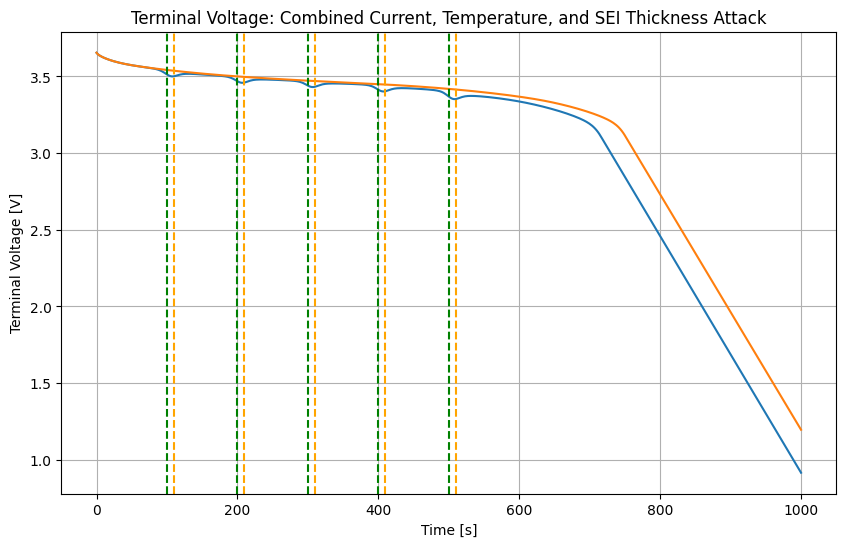

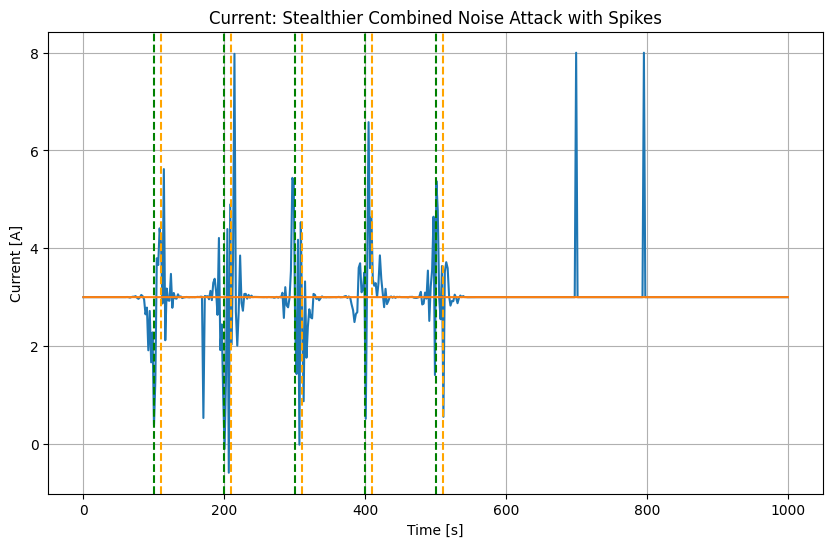

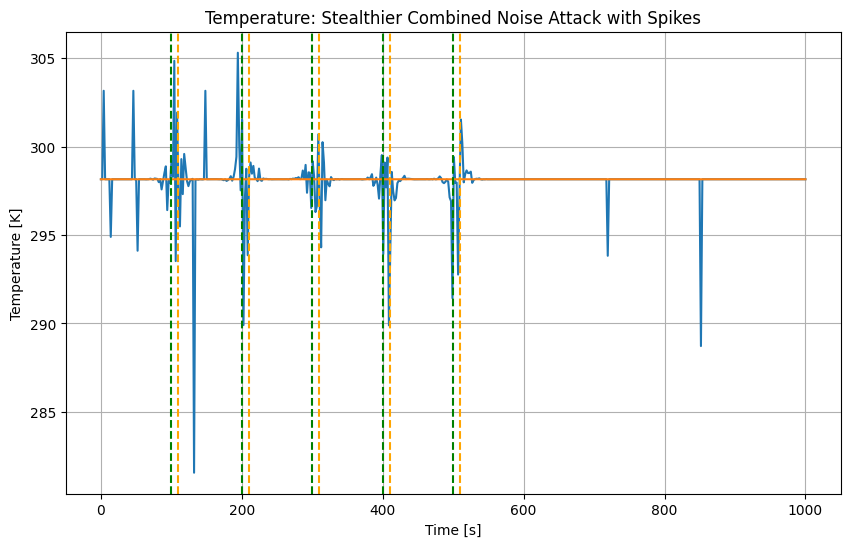

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Define five attack windows with start and end times
attack_windows = [
    (100, 110),
    (200, 210),
    (300, 310),
    (400, 410),
    (500, 510)
]

# Set the noise levels to 0.5e+1 and 0.001
noise_levels = [0.5e+1, 0.001]

# Time evaluation
t_eval = np.linspace(0, 1000, 500)

# Solver setup
solver = pybamm.CasadiSolver()
solver.max_steps = 50000  # Increase the max number of steps to avoid early termination
solver.rtol = 1e-6  # Relax relative tolerance
solver.atol = 1e-8  # Relax absolute tolerance
solver.dt_max = 1e-2  # Limit max time step to avoid excessive small steps

# Solve the model without adversarial attack (normal scenario)
sim_normal = pybamm.Simulation(model, parameter_values=param, solver=solver)
solution_normal = sim_normal.solve(t_eval)
voltage_normal = solution_normal["Terminal voltage [V]"].entries

# Adversarial current function with spikes limited to attack window and within noise range
def adversarial_current_pyBAMM(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_current = 3  # Constant 3A discharge

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # Generate Gaussian noise during the attack windows
    noise = attack_window * noise_amplitude * np.random.normal()

    # Use the heaviside function to model spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * noise_amplitude * np.random.normal(), noise_amplitude)

    return base_current + noise + spike

# Adversarial temperature function using attack windows and within noise range
def adversarial_temperature_pyBAMM(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_temperature = 298.15  # Nominal temperature 298.15K (25°C)

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # Generate Gaussian noise during the attack windows
    noise = attack_window * noise_amplitude * np.random.normal()

    # Introduce occasional high spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * noise_amplitude * np.random.normal(), noise_amplitude)

    return base_temperature + noise + spike

# Adversarial SEI thickness function using attack windows and within noise range
def adversarial_sei_thickness_pyBAMM(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_sei_thickness = param["Initial outer SEI thickness [m]"]

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # Generate Gaussian noise during the attack window
    noise = attack_window * noise_amplitude * np.random.normal()

    # Introduce occasional high spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * noise_amplitude * np.random.normal(), noise_amplitude)

    return base_sei_thickness + noise + spike

# Store voltage profiles for different noise levels
voltage_profiles = {}

for noise_amplitude in noise_levels:
    # Update parameters with adversarial current, temperature, and SEI thickness attack functions
    param.update({
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, noise_amplitude),
        "Ambient temperature [K]": adversarial_temperature_pyBAMM(pybamm.t, noise_amplitude),
        "Initial outer SEI thickness [m]": adversarial_sei_thickness_pyBAMM(pybamm.t, noise_amplitude),
    }, check_already_exists=False)

    # Solve the model with adversarial attack
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
   
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles[noise_amplitude] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for noise amplitude: {noise_amplitude}")

# Plot the voltage profiles for different noise levels
plt.figure(figsize=(10, 6))

# Plot voltage profiles with different noise levels
for noise_level, voltage_profile in voltage_profiles.items():
    plt.plot(t_eval, voltage_profile, label=f"Noise Amplitude {noise_level:.1e}")

# Attack window lines
for start, end in attack_windows:
    plt.axvline(x=start, color='green', linestyle='--', label="Attack Start")
    plt.axvline(x=end, color='orange', linestyle='--', label="Attack End")

# Labeling the plot
plt.xlabel("Time [s]")
plt.ylabel("Terminal Voltage [V]")
plt.title("Terminal Voltage: Combined Current, Temperature, and SEI Thickness Attack")
#plt.legend()
plt.grid(True)
plt.savefig("terminal_voltage_combined_attack_with_spikes11.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Define the plotting-friendly version for adversarial current (uses NumPy)
def adversarial_current_plot(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_current = 3  # Constant 3A discharge

    # Attack window for all windows combined using numpy functions
    attack_window = np.sum([0.5 * (1 + np.tanh((t - start) / 10)) * 0.5 * (1 + np.tanh((end - t) / 10)) for start, end in attack_windows], axis=0)

    # Generate Gaussian noise during the attack window
    noise = attack_window * noise_amplitude * np.random.normal(0, 1, len(t))

    # Introduce occasional high spikes within the attack window and limit spikes to within a range
    spike_mask = (np.random.rand(len(t)) < spike_probability)
    noise[spike_mask] += np.minimum(spike_factor * noise_amplitude * np.random.normal(0, 1, sum(spike_mask)), noise_amplitude)

    return base_current + noise

# Plot the current profile
plt.figure(figsize=(10, 6))

# Plot current profile with both noise levels
for noise_amplitude in noise_levels:
    current_profile = adversarial_current_plot(t_eval, noise_amplitude)
    plt.plot(t_eval, current_profile, label=f"Noise Amplitude {noise_amplitude:.1e}")

# Attack window lines
for start, end in attack_windows:
    plt.axvline(x=start, color='green', linestyle='--', label="Attack Start")
    plt.axvline(x=end, color='orange', linestyle='--', label="Attack End")

# Labeling the plot
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")
plt.title("Current: Stealthier Combined Noise Attack with Spikes")
#plt.legend()
plt.grid(True)
plt.savefig("current_combined_attack_with_spikes11.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Define the plotting-friendly version for adversarial temperature (uses NumPy)
def adversarial_temperature_plot(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_temperature = 298.15  # Nominal temperature 298.15K (25°C)

    # Attack window for all windows combined using numpy functions
    attack_window = np.sum([0.5 * (1 + np.tanh((t - start) / 10)) * 0.5 * (1 + np.tanh((end - t) / 10)) for start, end in attack_windows], axis=0)

    # Generate Gaussian noise during the attack window
    noise = attack_window * noise_amplitude * np.random.normal(0, 1, len(t))

    # Introduce occasional high spikes within the attack window and limit spikes to within a range
    spike_mask = (np.random.rand(len(t)) < spike_probability)
    noise[spike_mask] += np.minimum(spike_factor * noise_amplitude * np.random.normal(0, 1, sum(spike_mask)), noise_amplitude)

    return base_temperature + noise

# Plot the temperature profiles for different noise levels
plt.figure(figsize=(10, 6))

# Plot temperature profile with both noise levels
for noise_amplitude in noise_levels:
    temperature_profile = adversarial_temperature_plot(t_eval, noise_amplitude)
    plt.plot(t_eval, temperature_profile, label=f"Noise Amplitude {noise_amplitude:.1e}")

# Attack window lines
for start, end in attack_windows:
    plt.axvline(x=start, color='green', linestyle='--', label="Attack Start")
    plt.axvline(x=end, color='orange', linestyle='--', label="Attack End")

# Labeling the plot
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Temperature: Stealthier Combined Noise Attack with Spikes")
#plt.legend()
plt.grid(True)
plt.savefig("temperature_combined_attack_with_spikes11.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Define five attack windows with start and end times
attack_windows = [
    (100, 110),
    (200, 210),
    (300, 310),
    (400, 410),
    (500, 510)
]

# Set the noise levels for sensitivity analysis
noise_levels = [0.5e+0, 1e+0, 1.5e+0, 2e+0]

# Time evaluation
t_eval = np.linspace(0, 1000, 500)

# Solver setup
solver = pybamm.CasadiSolver()
solver.max_steps = 50000  # Increase the max number of steps to avoid early termination
solver.rtol = 1e-6  # Relax relative tolerance
solver.atol = 1e-8  # Relax absolute tolerance
solver.dt_max = 1e-2  # Limit max time step to avoid excessive small steps

# Solve the model without adversarial attack (normal scenario)
sim_normal = pybamm.Simulation(model, parameter_values=param, solver=solver)
solution_normal = sim_normal.solve(t_eval)
voltage_normal = solution_normal["Terminal voltage [V]"].entries

# Define a function to model adversarial current based on noise level
def adversarial_current_pyBAMM(t, noise_amplitude, spike_probability=0.01, spike_factor=2):
    base_current = 3  # Constant 3A discharge

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # Generate Gaussian noise during the attack windows
    noise = attack_window * noise_amplitude * np.random.normal()

    # Use the heaviside function to model spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * noise_amplitude * np.random.normal(), noise_amplitude)

    return base_current + noise + spike

# Store voltage profiles for different noise levels
voltage_profiles = {}

for noise_amplitude in noise_levels:
    # Update parameters with adversarial current attack function
    param.update({
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, noise_amplitude)
    }, check_already_exists=False)

    # Solve the model with adversarial attack
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
   
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles[noise_amplitude] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for noise amplitude: {noise_amplitude}")

# Define the output directory
output_dir = os.path.join(os.getcwd(), '..', 'Images')
os.makedirs(output_dir, exist_ok=True)

# Plot 1: The full voltage profile
plt.figure(figsize=(10, 6))

# Increase font size
plt.rc('font', size=12)

# Plot voltage profiles with different noise levels
for noise_level, voltage_profile in voltage_profiles.items():
    plt.plot(t_eval, voltage_profile, label=f"Noise Amplitude {noise_level:.1e}")

# Attack window lines
for start, end in attack_windows:
    plt.axvline(x=start, color='green', linestyle='--', label="Attack Start")
    plt.axvline(x=end, color='orange', linestyle='--', label="Attack End")

# Labeling the plot
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Noise Levels (Full Simulation)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Save the figure as a PDF
plt.savefig(os.path.join(output_dir, 'voltage_full_simulation.pdf'), format='pdf', bbox_inches='tight')
plt.close()

# Plot 2: Zoomed-in plot focusing on the voltage collapse (600-1000 seconds)
plt.figure(figsize=(10, 6))

# Plot zoomed-in voltage profiles
for noise_level, voltage_profile in voltage_profiles.items():
    plt.plot(t_eval, voltage_profile, label=f"Noise Amplitude {noise_level:.1e}")

# Zoom into the region of interest (600-1000 seconds)
plt.xlim(600, 1000)
plt.ylim(0.9, 2.5)

# Labeling the plot
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Noise Levels (Zoomed-In Collapse Region)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Save the figure as a PDF
plt.savefig(os.path.join(output_dir, 'voltage_zoomed_collapse.pdf'), format='pdf', bbox_inches='tight')
plt.close()


In [4]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Reset noise levels to default (no noise)
default_noise_level = 0.0

# Define five attack windows with start and end times (keeping them the same)
attack_windows = [
    (100, 110),
    (200, 210),
    (300, 310),
    (400, 410),
    (500, 510)
]

# Time evaluation
t_eval = np.linspace(0, 1000, 500)

# Solver setup
solver = pybamm.CasadiSolver()
solver.max_steps = 50000  # Increase the max number of steps to avoid early termination
solver.rtol = 1e-6  # Relax relative tolerance
solver.atol = 1e-8  # Relax absolute tolerance
solver.dt_max = 1e-2  # Limit max time step to avoid excessive small steps

# Define ranges for sensitivity analysis for initial SoC, SEI resistance, and electrolyte concentration
initial_soc_range = [0.2, 0.5, 0.8]  # Low, medium, high initial SoC
sei_resistance_range = [1e-3, 2e-3, 5e-3]  # Different SEI resistance values
electrolyte_concentration_range = [1.0e3, 1.5e3, 2.0e3]  # Different electrolyte concentrations (mol/m^3)

# Function to model adversarial current with no noise
def adversarial_current_pyBAMM(t, noise_amplitude=0.0, spike_probability=0.01, spike_factor=2):
    base_current = 3  # Constant 3A discharge
    return base_current  # No noise for this scenario

# Create output directory if not exists
output_dir = os.path.join(os.getcwd(), '..', 'Images')
os.makedirs(output_dir, exist_ok=True)

# Store results for each parameter
voltage_profiles_soc = {}
voltage_profiles_sei = {}
voltage_profiles_electrolyte = {}

# Sensitivity analysis for initial SoC
for initial_soc in initial_soc_range:
    # Update parameters
    param.update({
        "Initial State of Charge": initial_soc,
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, default_noise_level)
    }, check_already_exists=False)

    # Solve the model with modified initial SoC
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_soc[initial_soc] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for initial SoC: {initial_soc}")

# Sensitivity analysis for SEI resistance
for sei_resistance in sei_resistance_range:
    # Update parameters
    param.update({
        "Initial outer SEI thickness [m]": sei_resistance,
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, default_noise_level)
    }, check_already_exists=False)

    # Solve the model with modified SEI resistance
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_sei[sei_resistance] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for SEI resistance: {sei_resistance}")

# Sensitivity analysis for electrolyte concentration
for electrolyte_concentration in electrolyte_concentration_range:
    # Update parameters
    param.update({
        "Initial electrolyte concentration [mol.m-3]": electrolyte_concentration,
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, default_noise_level)
    }, check_already_exists=False)

    # Solve the model with modified electrolyte concentration
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_electrolyte[electrolyte_concentration] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for electrolyte concentration: {electrolyte_concentration}")

# Plot results for Initial SoC sensitivity
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for initial_soc, voltage_profile in voltage_profiles_soc.items():
    plt.plot(t_eval, voltage_profile, label=f"Initial SoC {initial_soc}")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Initial SoC", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_sensitivity_soc.pdf'), format='pdf', bbox_inches='tight')
plt.close()

# Plot results for SEI resistance sensitivity
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for sei_resistance, voltage_profile in voltage_profiles_sei.items():
    plt.plot(t_eval, voltage_profile, label=f"SEI Resistance {sei_resistance} m")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to SEI Resistance", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_sensitivity_sei.pdf'), format='pdf', bbox_inches='tight')
plt.close()

# Plot results for electrolyte concentration sensitivity
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for electrolyte_concentration, voltage_profile in voltage_profiles_electrolyte.items():
    plt.plot(t_eval, voltage_profile, label=f"Electrolyte Conc {electrolyte_concentration:.1e} mol/m^3")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Electrolyte Concentration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_sensitivity_electrolyte.pdf'), format='pdf', bbox_inches='tight')
plt.close()


In [5]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Reset noise levels to default (no noise)
default_noise_level = 0.0

# Time evaluation
t_eval = np.linspace(0, 1000, 500)

# Solver setup
solver = pybamm.CasadiSolver()
solver.max_steps = 50000  # Increase the max number of steps to avoid early termination
solver.rtol = 1e-6  # Relax relative tolerance
solver.atol = 1e-8  # Relax absolute tolerance
solver.dt_max = 1e-2  # Limit max time step to avoid excessive small steps

# Define a function to model adversarial current (with extreme perturbation amplitude options)
def adversarial_current_pyBAMM(t, noise_amplitude=0.0, spike_probability=0.01, spike_factor=2, perturbation_amplitude=0.01):
    base_current = 3  # Constant 3A discharge

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # No noise, but adding perturbation amplitude
    noise = attack_window * perturbation_amplitude

    # Use the heaviside function to model spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * perturbation_amplitude, perturbation_amplitude)

    return base_current + noise + spike

# Sensitivity analysis: More extreme attack windows
attack_window_sets = [
    [(100, 102), (200, 202)],  # Very short attack windows
    [(100, 180), (300, 380)],  # Very long attack windows
    [(100, 110), (200, 210), (300, 310), (400, 410), (500, 510)]  # Original attack windows
]

# Sensitivity analysis: More extreme perturbation amplitudes
perturbation_amplitudes = [0.001, 0.01, 0.05, 0.2, 0.5]  # Very small to very large perturbation amplitudes

# Create output directory if not exists
output_dir = os.path.join(os.getcwd(), '..', 'Images')
os.makedirs(output_dir, exist_ok=True)

# Store voltage profiles for different attack windows and perturbation amplitudes
voltage_profiles_attack_windows = {}
voltage_profiles_perturbation_amplitude = {}

# Loop over different attack window sets
for i, attack_windows in enumerate(attack_window_sets):
    # Update parameters
    param.update({
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, perturbation_amplitude=0.05)  # Keep perturbation amplitude fixed for now
    }, check_already_exists=False)

    # Solve the model with different attack windows
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_attack_windows[f"Attack Window Set {i+1}"] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for attack window set {i+1}")

# Loop over different perturbation amplitudes
for perturbation_amplitude in perturbation_amplitudes:
    # Update parameters
    param.update({
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, perturbation_amplitude=perturbation_amplitude)
    }, check_already_exists=False)

    # Solve the model with different perturbation amplitudes
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_perturbation_amplitude[perturbation_amplitude] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for perturbation amplitude: {perturbation_amplitude}")

# Plot 3: The full voltage profile for perturbation amplitudes
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for perturbation_amplitude, voltage_profile in voltage_profiles_perturbation_amplitude.items():
    plt.plot(t_eval, voltage_profile, label=f"Perturbation Amplitude {perturbation_amplitude:.3f}")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Perturbation Amplitudes (Full Simulation)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_perturbation_full_simulation.pdf'), format='pdf', bbox_inches='tight')
plt.close()

# Plot 4: Zoomed-in plot for perturbation amplitudes (600-1000 seconds)
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for perturbation_amplitude, voltage_profile in voltage_profiles_perturbation_amplitude.items():
    plt.plot(t_eval, voltage_profile, label=f"Perturbation Amplitude {perturbation_amplitude:.3f}")
plt.xlim(600, 1000)  # Zoom in
plt.ylim(0.9, 2.5)  # Adjust y-limits for collapse region
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Perturbation Amplitudes (Zoomed-In Collapse Region)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_perturbation_zoomed_simulation.pdf'), format='pdf', bbox_inches='tight')
plt.close()


In [6]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Reset noise levels to default (no noise)
default_noise_level = 0.0

# Time evaluation
t_eval = np.linspace(0, 1000, 500)

# Solver setup
solver = pybamm.CasadiSolver()
solver.max_steps = 50000  # Increase the max number of steps to avoid early termination
solver.rtol = 1e-6  # Relax relative tolerance
solver.atol = 1e-8  # Relax absolute tolerance
solver.dt_max = 1e-2  # Limit max time step to avoid excessive small steps

# Define a function to model adversarial current (with extreme perturbation amplitude options)
def adversarial_current_pyBAMM(t, noise_amplitude=0.0, spike_probability=0.01, spike_factor=2, perturbation_amplitude=0.01):
    base_current = 3  # Constant 3A discharge

    # Attack window for all windows combined
    attack_window = sum(0.5 * (1 + pybamm.tanh((t - start) / 10)) * 0.5 * (1 + pybamm.tanh((end - t) / 10)) for start, end in attack_windows)

    # No noise, but adding perturbation amplitude
    noise = attack_window * perturbation_amplitude

    # Use the heaviside function to model spikes within the attack window and limit spikes to within a range
    spike = pybamm.sign(attack_window) * (np.random.rand() < spike_probability) * min(spike_factor * perturbation_amplitude, perturbation_amplitude)

    return base_current + noise + spike

# Sensitivity analysis: More extreme attack windows
attack_window_sets = [
    [(100, 101), (200, 201)],  # Extremely short attack windows (1 second bursts)
    [(100, 500)],  # Single long attack window (half of the simulation time)
    [(50, 100), (150, 300), (350, 400), (500, 700)],  # Multiple long attack windows
    [(100, 110), (200, 210), (300, 310), (400, 410), (500, 510)]  # Original attack windows
]

# Sensitivity analysis: Perturbation amplitude fixed for attack window comparison
perturbation_amplitude = 0.05

# Create output directory if not exists
output_dir = os.path.join(os.getcwd(), '..', 'Images')
os.makedirs(output_dir, exist_ok=True)

# Store voltage profiles for different attack windows
voltage_profiles_attack_windows = {}

# Loop over different attack window sets
for i, attack_windows in enumerate(attack_window_sets):
    # Update parameters
    param.update({
        "Current function [A]": adversarial_current_pyBAMM(pybamm.t, perturbation_amplitude=perturbation_amplitude)  # Use fixed perturbation amplitude for comparison
    }, check_already_exists=False)

    # Solve the model with different attack windows
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    try:
        solution = sim.solve(t_eval)
        voltage = solution["Terminal voltage [V]"].entries
        time_temp = solution["Time [s]"].entries

        # Interpolate voltage to match t_eval
        voltage_interp = interp1d(time_temp, voltage, kind="linear", fill_value="extrapolate")
        voltage_profiles_attack_windows[f"Attack Window Set {i+1}"] = voltage_interp(t_eval)

    except pybamm.SolverError:
        print(f"Solver failed for attack window set {i+1}")

# Plot 1: Full voltage profile for different attack windows
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for attack_window_set, voltage_profile in voltage_profiles_attack_windows.items():
    plt.plot(t_eval, voltage_profile, label=f"{attack_window_set}")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Extreme Attack Windows (Full Simulation)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_attack_windows_full_simulation.pdf'), format='pdf', bbox_inches='tight')
plt.close()

# Plot 2: Zoomed-in plot focusing on voltage collapse (600-1000 seconds)
plt.figure(figsize=(10, 6))
plt.rc('font', size=12)
for attack_window_set, voltage_profile in voltage_profiles_attack_windows.items():
    plt.plot(t_eval, voltage_profile, label=f"{attack_window_set}")
plt.xlim(600, 1000)  # Zoom in on the collapse region
plt.ylim(0.9, 2.5)   # Adjust y-limits to focus on voltage collapse
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Terminal Voltage [V]", fontsize=14)
plt.title("Terminal Voltage: Sensitivity to Extreme Attack Windows (Zoomed-In Collapse Region)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'voltage_attack_windows_zoomed_simulation.pdf'), format='pdf', bbox_inches='tight')
plt.close()
